Characterization of the GPR sampler for learning a landscape. Error seems to decay exponentially in simple landscapes.

In [1]:
%pylab inline
plt.rc('font',size=20)

Populating the interactive namespace from numpy and matplotlib


In [2]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF,ConstantKernel

# Radial coordinate system GPR.

In [ ]:
from perceptionneuron.coherence import GPR
noise_scale = 1e-1
gpr = GPR(alpha=noise_scale,length_scale=array([2,.2]))

# Define sigmoid function.
random.RandomState(0)

# Tanh function [-1,1] expanded to .
def fun_z(theta,invr):
    return ((1-invr)*cos(-theta)+(1-invr)*sin(-theta))-.5

xy0 = np.array([[random.rand()*2,random.rand()]])
z = fun_z(xy0[0,0],xy0[0,1])+random.normal(scale=noise_scale)
obj = reshape([fun_z(i,j) for i,j in gpr.meshPoints],(10,16))

gpr.update(z,*xy0[0])

In [990]:
# Pick next point where uncertainty is maximized.
newt,newf = gpr.max_uncertainty()

totalErr = [norm(gpr.coherence_pred-obj.ravel())]
totalVar = [(gpr.std_pred**2).sum()]
maxVar = [gpr.std_pred.max()**2]

counter = 0
# while linalg.norm(gpr.coherence_pred-obj.ravel()).max()>1:
while counter<50 and norm(gpr.coherence_pred-obj.ravel()).max()>1:
    gpr.update( fun_z(newt,newf)+random.normal(scale=noise_scale),newt,newf )
    newt,newf = gpr.max_uncertainty()
    
    totalErr.append( linalg.norm(gpr.coherence_pred-obj.ravel()) )
    totalVar.append((gpr.std_pred**2).sum())
    maxVar.append(gpr.std_pred.max()**2)
    counter += 1
totalVar = array(totalVar)

[[], <matplotlib.text.Text at 0x7fd687f0bd90>]

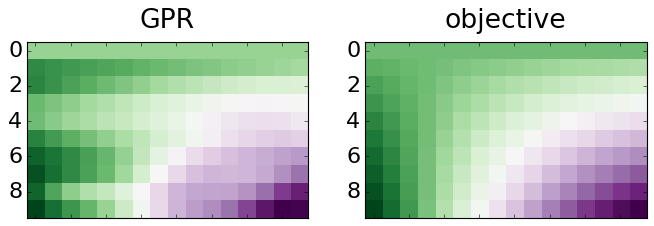

In [994]:
fig,ax = plt.subplots(figsize=(10,4),ncols=2)
ax[0].matshow(gpr.coherence_pred.reshape(10,16)[::-1],cmap=plt.cm.PRGn)
ax[1].matshow(obj[::-1],cmap=plt.cm.PRGn)
ax[0].set(title='GPR',xticklabels=[])
ax[1].set(title='objective',xticklabels=[])

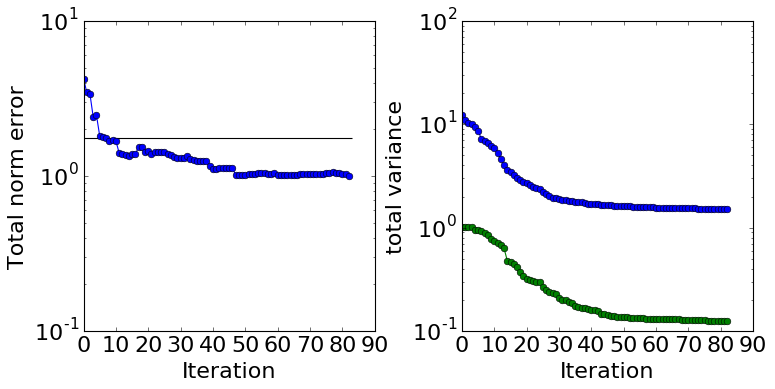

In [982]:
# Error decrease quickly at first, but there is a large regime where data collection does not help very much in learning the landscape. Not sure why exponential regime does not continue. Have we hit noise?
fig,ax = plt.subplots(figsize=(10.8,5),ncols=2)
x = arange(len(totalErr))

ax[0].semilogy(totalErr,'o-')
ax[0].hlines(noise_scale*160/sqrt(counter),0,len(totalErr))
ax[1].semilogy(sqrt(totalVar),'o-')
ax[1].semilogy(sqrt(maxVar),'o-')

ax[0].set(xlabel='Iteration',ylabel='Total norm error')
ax[1].set(xlabel='Iteration',ylabel='total variance')

fig.subplots_adjust(wspace=.3)

## Test selecting points closest to the contour.

In [1276]:
from perceptionneuron.coherence import GPR
noise_scale = 1e-1
gpr = GPR(alpha=noise_scale,length_scale=array([2,.2]))

# Define sigmoid function.
random.RandomState(0)

# Tanh function [-1,1] expanded to .
def fun_z(theta,invr):
    return ((1-invr)*cos(-theta)+(1-invr)*sin(-theta))-.5

xy0 = np.array([[random.rand()*2,random.rand()]])
z = fun_z(xy0[0,0],xy0[0,1])+random.normal(scale=noise_scale)
obj = reshape([fun_z(i,j) for i,j in gpr.meshPoints],(10,16))

gpr.update(z,*xy0[0])

# Pick next point where uncertainty is maximized.
newt,newf = gpr.max_uncertainty()

counter = 0
while counter<15:
    gpr.update( fun_z(newt,newf)+random.normal(scale=noise_scale),newt,newf )
    newt,newf = gpr.max_uncertainty()
    counter += 1

In [1288]:
# Pick next point along contour given by performance value.
newt,newf = gpr.select_contour(.3,choose_algo='err',
                               algo_kwargs={'threshold':.05,'std_scale':1})
gpr.update( fun_z(newt,newf)+random.normal(scale=noise_scale),newt,newf )
gpr.pointsToAvoid.append(concatenate([newt,newf]))
print newt,newf

72
[ 2.] [ 0.9]


[[], <matplotlib.text.Text at 0x7fd680264210>]

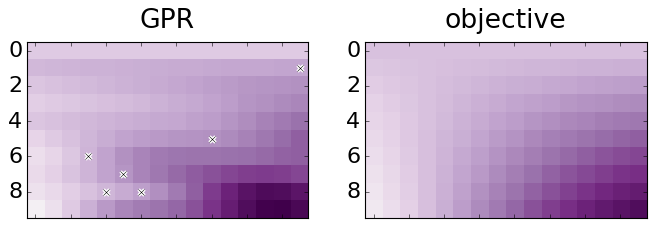

In [1289]:
fig,ax = plt.subplots(figsize=(10,4),ncols=2)
mx = abs(gpr.coherence_pred).max()
ax[0].matshow(gpr.coherence_pred.reshape(10,16)[::-1],
              cmap=plt.cm.PRGn,vmin=-mx,vmax=mx,zorder=0)
xlim,ylim = ax[0].get_xlim(),ax[0].get_ylim()
for x,y in gpr.pointsToAvoid:
    ax[0].plot( (x-.5)*10,(1-y)*10,'kx',zorder=2 )
    ax[0].plot( (x-.5)*10,(1-y)*10,'wx',mew=3,zorder=1 )
ax[1].matshow(obj[::-1],cmap=plt.cm.PRGn,
              vmin=-mx,vmax=mx)
ax[0].set(title='GPR',xticklabels=[],xlim=xlim,ylim=ylim)
ax[1].set(title='objective',xticklabels=[])

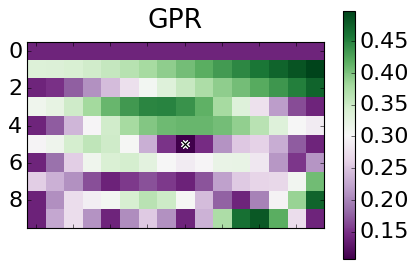

In [1239]:
fig,ax = plt.subplots()
cax = ax.matshow(gpr.std_pred.reshape(10,16)[::-1],
              cmap=plt.cm.PRGn,zorder=0)
xlim,ylim = ax.get_xlim(),ax.get_ylim()
for x,y in gpr.pointsToAvoid:
    ax.plot( (x-.5)*10,(1-y)*10,'kx',zorder=2 )
    ax.plot( (x-.5)*10,(1-y)*10,'wx',mew=3,zorder=1 )
ax.set(title='GPR',xticklabels=[],xlim=xlim,ylim=ylim)
fig.colorbar(cax)